In [33]:
#importing necessary libraries
import numpy as np
import scipy
import scipy.stats.stats as stat
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib
import seaborn as sb
from io import StringIO
import re
import matplotlib.pyplot as plt
import pandas as pd
import urllib3 as urllib
import csv
from sklearn.model_selection import train_test_split

%matplotlib inline

<h2>Downloading and Processing the Data</h2>

In [34]:
'''
Downloading the Data 
-Retrieve the echocardiogram data from the web address.
-Load the Data into a pandas dataframe
'''

# load in the data locally
with open('echocardiogram.data.txt') as input_file:
   lines = input_file.readlines()
   newLines = []
   for line in lines:
      newLine = line.strip().split(',')
      newLines.append( newLine )

with open('ecgData.csv', 'w') as test_file:
   file_writer = csv.writer(test_file)
   file_writer.writerows( newLines )
    
#Read the data into a pandas dataframe

columnNames = ['survival','still-alive','age-at-heart-attack','pericardial-effusion','fractional-shortening','epss','lvdd','wall-motion-score','wall-motion-index','mult','name','group','alive-at-1']
table = pd.read_csv('ecgData.csv',names=columnNames)

#Clear the useless columns:

uselessCols = ['mult','name','group']
table.drop(uselessCols, inplace=True, axis=1)
             

table

table = table.apply(pd.to_numeric, errors='coerce')

# Validate the data
def check_column(data,col):
    data[col] = data[col].replace('?',np.nan)
    return data[col]
#b)
def validate(data):
    for column in data:
        data[column]= check_column(data,column)
    return data

table = validate(table)

# Remove all na values:
table = table.dropna(axis=0, how='any')
table

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
0,11.00,0.0,71.000,0,0.260,9.000,4.600,14.00,1.000,0.0
1,19.00,0.0,72.000,0,0.380,6.000,4.100,14.00,1.700,0.0
2,16.00,0.0,55.000,0,0.260,4.000,3.420,14.00,1.000,0.0
3,57.00,0.0,60.000,0,0.253,12.062,4.603,16.00,1.450,0.0
4,19.00,1.0,57.000,0,0.160,22.000,5.750,18.00,2.250,0.0
5,26.00,0.0,68.000,0,0.260,5.000,4.310,12.00,1.000,0.0
6,13.00,0.0,62.000,0,0.230,31.000,5.430,22.50,1.875,0.0
7,50.00,0.0,60.000,0,0.330,8.000,5.250,14.00,1.000,0.0
8,19.00,0.0,46.000,0,0.340,0.000,5.090,16.00,1.140,0.0
9,25.00,0.0,54.000,0,0.140,13.000,4.490,15.50,1.190,0.0


# Logistic Regression:


age-at-heart-attack      float64
fractional-shortening    float64
lvdd                     float64
wall-motion-score        float64
dtype: object
Accuracy of logistic regression classifier on test set: 0.85


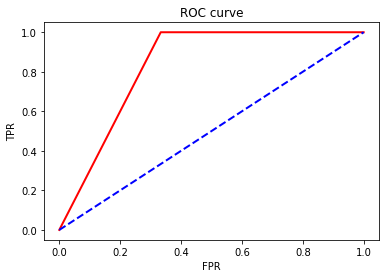

In [39]:
# Output Column (Can we predict if the patient is alive after 1 year?)
y = table[['still-alive']]
#Factors used to predict the output
x = table[['age-at-heart-attack','fractional-shortening','lvdd','wall-motion-score']]

xtrain, xtest = train_test_split(x, test_size=0.2, random_state = 1)
ytrain, ytest = train_test_split(y, test_size=0.2, random_state = 1)

print(xtrain.dtypes)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(xtrain,ytrain.values.ravel())

ypred = logreg.predict(xtest)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(xtest,ytest)) )


#ROC 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
fpr, tpr,_=roc_curve(logreg.predict(xtrain),ytrain,drop_intermediate=False)
plt.figure()
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# PCA:

In [22]:
# standardize the variables for which we will apply PCA

x_std = StandardScaler().fit_transform(x)

#apply PCA

pca = PCA(n_components=4)
y_pca = pca.fit_transform(x_std)

print(y_pca)


[[ -3.19224141e-01  -7.24736648e-01   4.92981424e-01  -6.30512609e-03]
 [ -1.37576123e+00  -8.14945235e-01   1.14873697e+00   3.99835607e-01]
 [ -1.74159661e+00   9.86223746e-01   1.67901585e-01  -8.68958513e-01]
 [ -4.60819909e-01   5.04540446e-01   1.92865238e-02   1.08790832e-01]
 [  1.04093081e+00   8.36375159e-01  -8.30774707e-01   5.22428855e-01]
 [ -8.00645255e-01  -6.07347283e-01   2.28807124e-01  -3.00254884e-01]
 [  9.04019698e-01   8.75923963e-01   3.96223369e-01   8.68715029e-01]
 [ -5.66064931e-01   8.43565464e-02  -4.10005269e-01   1.11065752e+00]
 [ -1.02791706e+00   1.60752209e+00  -9.36222528e-01   1.23079880e+00]
 [ -1.20101308e-01   1.12017931e+00  -6.38591620e-01  -7.41619128e-01]
 [  6.60105555e-01  -6.47780569e-01   1.25190301e+00  -1.11658155e+00]
 [ -2.32596134e+00   3.61911356e-01   1.22507325e+00   6.20105978e-01]
 [ -1.13121952e+00  -8.42204429e-01   1.14567888e+00  -3.88485071e-02]
 [ -7.02651522e-01   5.58936064e-01   2.88975780e-02  -1.41208247e+00]
 [  9.